# TLE-HC

**Overview**

Case-control difference mapping in temporal lobe epilepsy. This notebook will examine morphological features of the hippocampus in TLE patients. We compare the ipsilateral foci hippocampi to contralateral (asymmetry analysis), and to age-matched controls (case-control analysis).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import hippomaps as hm
import pandas as pd
from scipy.stats import ttest_1samp
import time
start_time = time.time()

In [2]:
# config

useCheckpoints = True
if useCheckpoints:
    hm.fetcher.get_tutorialCheckpoints(['TLE-HC.npz', 'participants_MICs_PX.csv', 'participants_MICs_HC.csv'])
    
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'

subs_PX = pd.read_csv(f'checkpoints/participants_MICs_PX.csv', delimiter=',')
subs_HC = pd.read_csv(f'checkpoints/participants_MICs_HC.csv', delimiter=',')
hemis = ['L','R']
labels = ['hipp']#,'dentate'] 
den = '0p5mm'

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

# loop through these types of structural images
features = ['thickness','gyrification','curvature','surfarea']

100% [............................................................] 3616 / 3616

## 0) Map and load volumetric data to surfaces

As in all tutorials here, this step is OPTIONAL, and will be skipped by default. It provides an example of how data can be mapped to hippocampal surfaces outside of python (using `wb_command`). This relies on having the data stored locally, and should be considered example code. This code may differ depending on where/how your data is stored and formatted, and so may require some customization for new projects. For the purposes of this tutorial, we provide a matrix of loaded data at the end, so skip to the next step.

In this example, we loop through samples (that is, subjects and hemipsheres) pulling hippunfold output features (that is, features intrinsic to the surfaces themselves, such as thickness).

In [3]:
if not useCheckpoints:

    # Load PX data
    hipp_dat_PX = np.zeros([nV,len(hemis),len(subs_PX['ID']),len(features)])*np.nan 
    for f,feature in enumerate(features):
        for s,sub in enumerate(subs_PX['ID']):
            for h,hemi in enumerate(hemis):  
                for l,label in enumerate(labels):
                    ses = subs_PX['SES'][s]
                    if subs_PX['pathology'][s][0] == hemi:
                        ic = 0 # always put ipsi first
                    else:
                        ic=1 # contra second
                    fn = f'{hippunfold_dir}/{sub}/{ses}/surf/{sub}_{ses}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_{feature}.shape.gii'
                    if feature=='curvature' and hemi == 'R':
                        hipp_dat_PX[iV[l],ic,s,f] = -nib.load(fn).darrays[0].data
                    else:
                        hipp_dat_PX[iV[l],ic,s,f] = nib.load(fn).darrays[0].data

    # Load HC data
    hipp_dat_HC = np.zeros([nV,len(hemis),len(subs_HC['ID']),len(features)])*np.nan 
    for f,feature in enumerate(features):
        for s,sub in enumerate(subs_HC['ID']):
            for h,hemi in enumerate(hemis):  
                for l,label in enumerate(labels):
                    ses = subs_HC['SES'][s]
                    fn = f'{hippunfold_dir}/{sub}/{ses}/surf/{sub}_{ses}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_{feature}.shape.gii'
                    if feature=='curvature' and hemi == 'R':
                        hipp_dat_HC[iV[l],h,s,f] = -nib.load(fn).darrays[0].data
                    else:
                        hipp_dat_HC[iV[l],h,s,f] = nib.load(fn).darrays[0].data

    np.savez_compressed("checkpoints/TLE-HC",hipp_dat_PX, hipp_dat_HC)

In [4]:
# overview demographics of patients

print(f"mean age: {np.mean(subs_PX['AGE'])} +/- {np.std(subs_PX['AGE'])}")
print(f"M/F: {np.sum(subs_PX['SEX']=='M')}/{np.sum(subs_PX['SEX']=='F')}")
print(f"L/R: {np.sum(subs_PX['pathology']=='Right TLE')}/{np.sum(subs_PX['pathology']=='Left TLE')}")

mean age: 38.8 +/- 11.63688716354777
M/F: 17/18
L/R: 15/20


In [5]:
# overview demographics of controls

print(f"mean age: {np.mean(subs_HC['AGE'])} +/- {np.std(subs_HC['AGE'])}")
print(f"M/F: {np.sum(subs_HC['SEX']=='M')}/{np.sum(subs_HC['SEX']=='F')}")

mean age: 32.9375 +/- 12.031566554277127
M/F: 42/39


In [6]:
# Here we calculate and add a new feature: columnar volume. This is simply thicknes (mm) * surface area (mm2) giving a units in mm3.

hipp_dat_PX = np.load("checkpoints/TLE-HC.npz")['arr_0']
hipp_dat_HC= np.load("checkpoints/TLE-HC.npz")['arr_1']

coolumnar_volume = hipp_dat_PX[:,:,:,0]*hipp_dat_PX[:,:,:,3]
hipp_dat_PX = np.concatenate((hipp_dat_PX,coolumnar_volume.reshape([nV,len(hemis),len(subs_PX['ID']),1])),axis=3)

coolumnar_volume = hipp_dat_HC[:,:,:,0]*hipp_dat_HC[:,:,:,3]
hipp_dat_HC = np.concatenate((hipp_dat_HC,coolumnar_volume.reshape([nV,len(hemis),len(subs_HC['ID']),1])),axis=3)

features.append('columnarVol')

## 1) plot group-averages

Here we plot averages of the ipsilateral seizure focus, contralalteral, and healthy controls. We then compare ipsilateral to contralalteral (an asymmetry analysis) and ipsilateral to controls (case-control differences). Asymmetry is nice since it includes perfect matching on things like demographics, etc., but in cases with severe epilepsy there can also be abnormalities or secondary epileptogenic zones in the contralateral hemisphere as well. Case-control differences are less closely matched, but we can be confident that the HC data is normative. 

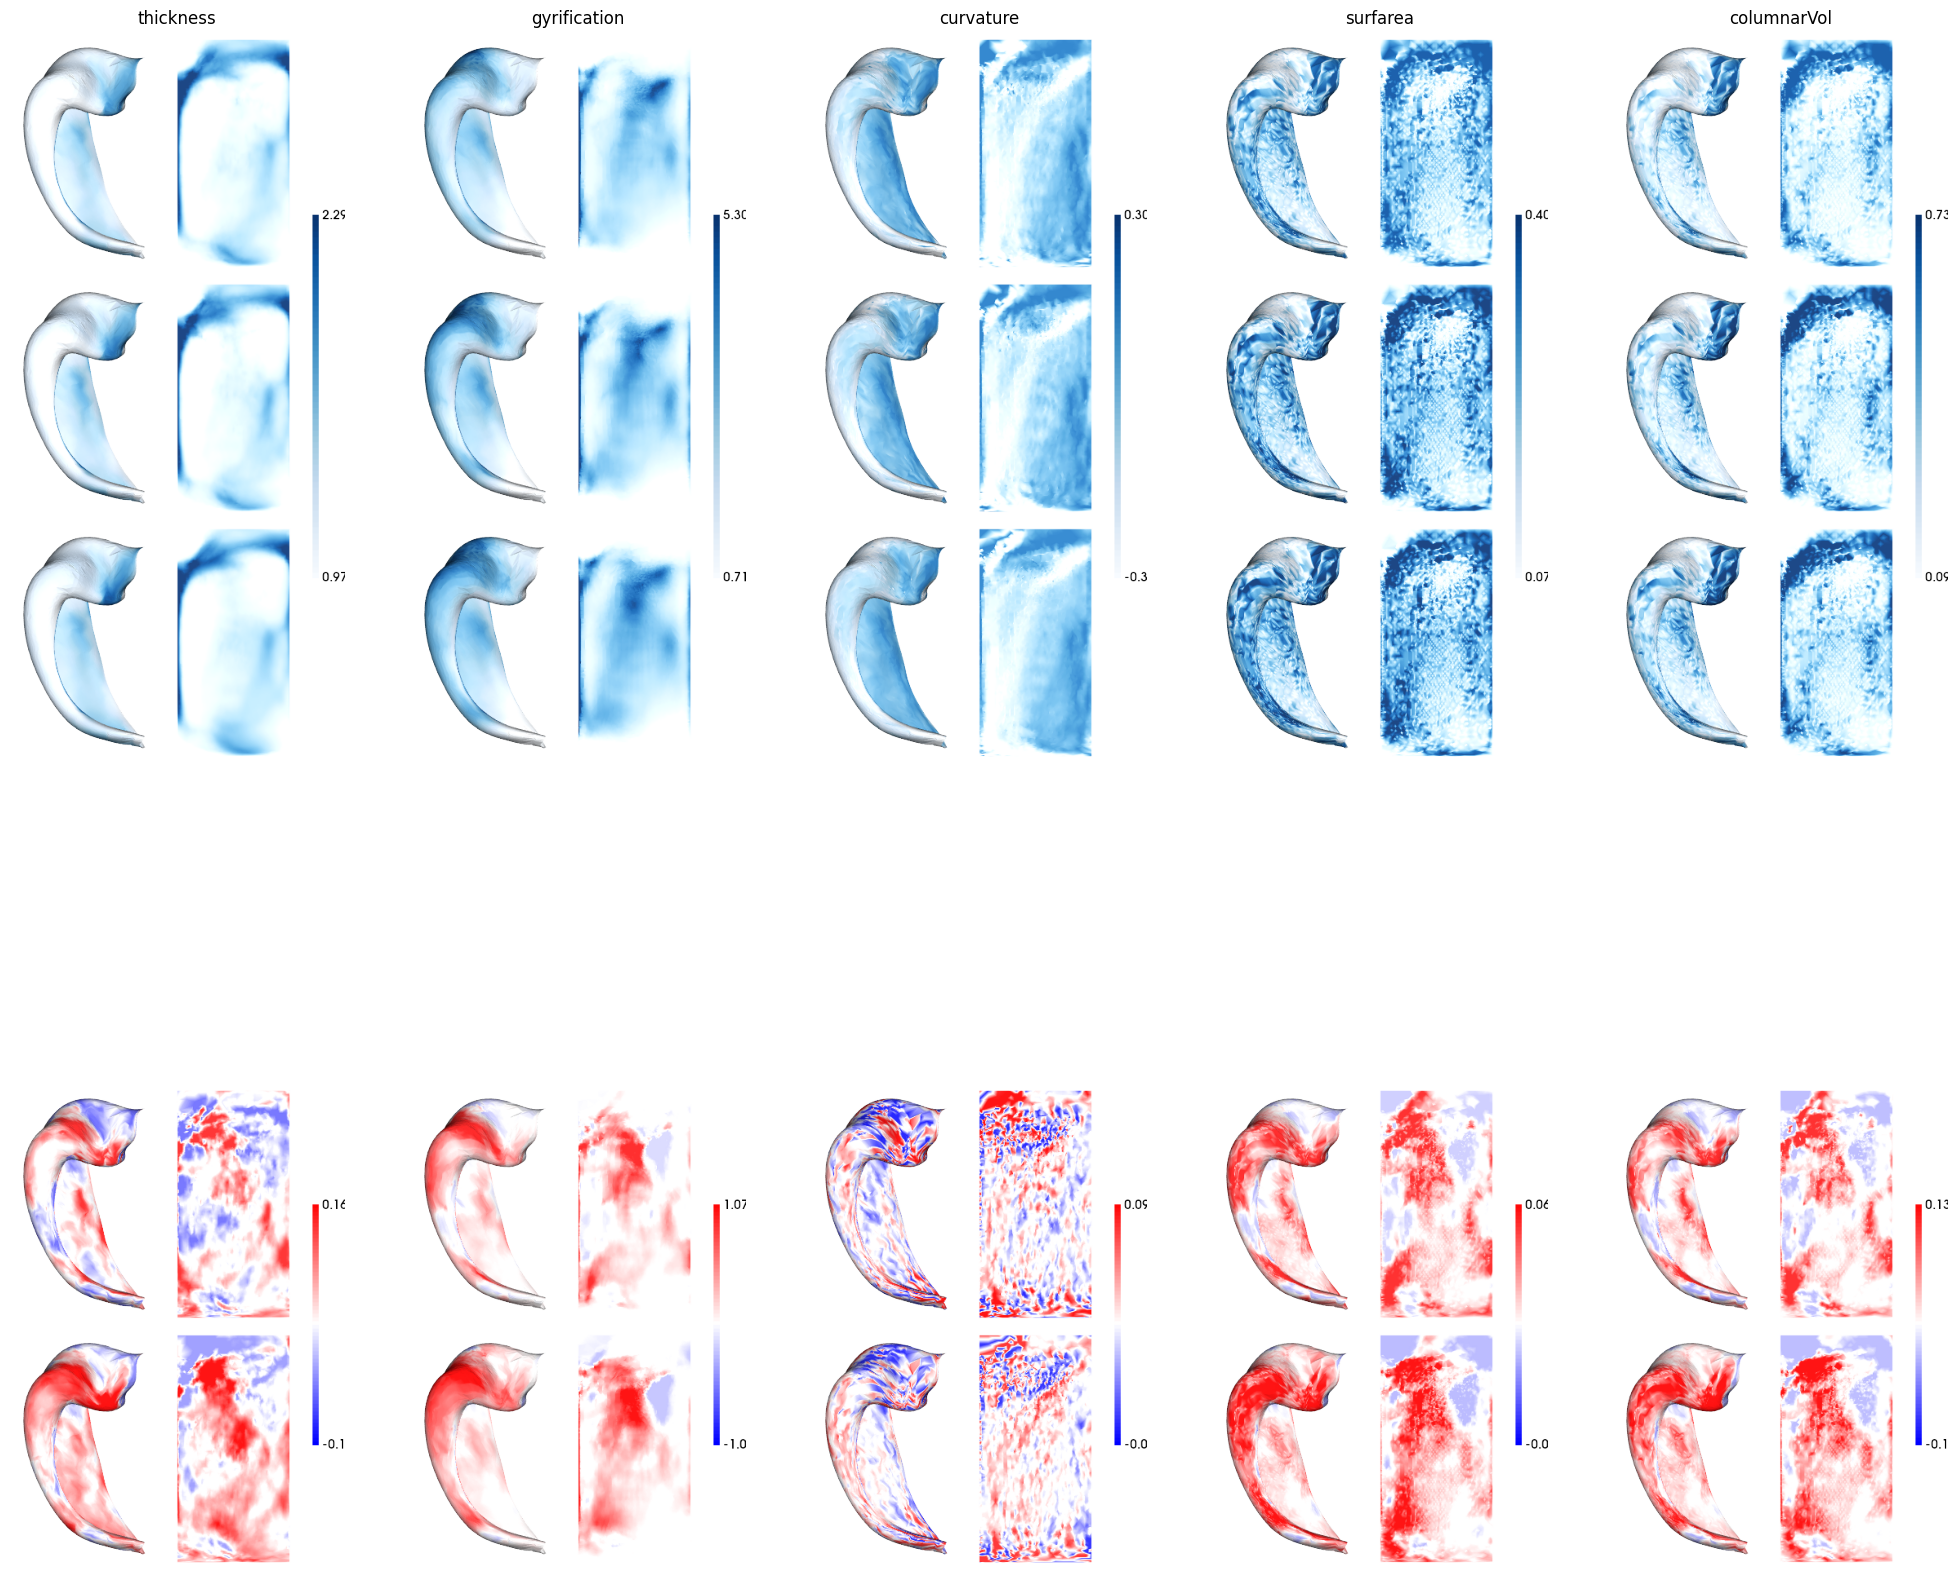

In [7]:
ipsilateral = np.mean(hipp_dat_PX[:,0,:,:], axis=1)
contralateral = np.mean(hipp_dat_PX[:,1,:,:], axis=1)
ctrl = np.mean(hipp_dat_HC,axis=(1,2))
asymmetry = contralateral-ipsilateral
caseCtrl = ctrl-ipsilateral

cdata1 = np.stack((ipsilateral,contralateral,ctrl),axis=2) # these will share color range
cdata2 = np.stack((asymmetry,caseCtrl),axis=2) # these will share their own separate color range

# plot altogether
fig, ax = plt.subplots(2,5, figsize=(25,25))
for f in range(5):
    hm.plotting.surfplot_canonical_foldunfold(cdata1[:,f,:], color_bar=('right'), hemis=['L'], labels=['hipp'], cmap='Blues', color_range='sym', unfoldAPrescale=True, share='both', tighten_cwindow=True, embed_nb=True, screenshot=True, filename='tmp.png')
    i = plt.imread('tmp.png')
    ax[0,f].imshow(i)
    ax[0,f].set_axis_off()
    ax[0,f].set_anchor("NW")
    ax[0,f].set_title(features[f])
    hm.plotting.surfplot_canonical_foldunfold(cdata2[:,f,:], color_bar=('right'), hemis=['L'], labels=['hipp'], cmap='bwr', color_range='sym', unfoldAPrescale=True, share='both', tighten_cwindow=True, embed_nb=True, screenshot=True, filename='tmp.png')
    i = plt.imread('tmp.png')
    ax[1,f].imshow(i)
    ax[1,f].set_axis_off()
    ax[1,f].set_anchor("NW")
    
!rm tmp.png

## 2) Examine inter-patient (ipsilateral) consistency

Here, we focus only on case-control differences for each ipsilateral hippocampus to the control average.

Ttest_1sampResult(statistic=4.876997145961732, pvalue=2.278470962511642e-06)
Ttest_1sampResult(statistic=6.4575080753712335, pvalue=8.76151025412419e-10)
Ttest_1sampResult(statistic=15.186544536003135, pvalue=1.431884784956529e-34)
Ttest_1sampResult(statistic=6.88452310563634, pvalue=8.317160023756746e-11)
Ttest_1sampResult(statistic=6.688206318715512, pvalue=2.4820341157259765e-10)


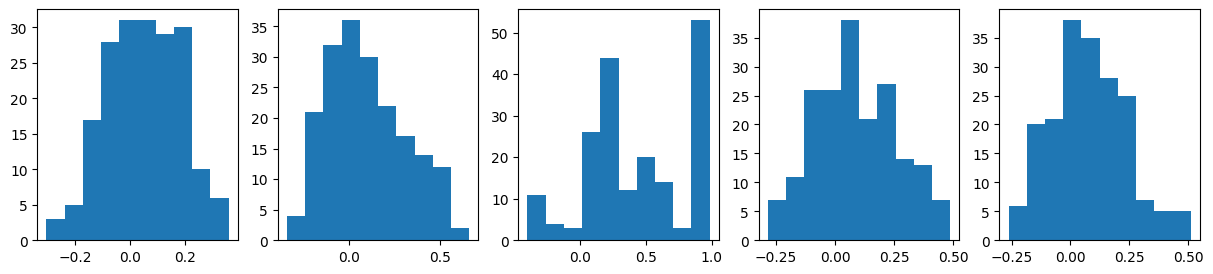

In [8]:
# make a histogram of the off-diagonal cross-patient correlations (minus controls average)
mfcorr = []
sdfcorr = []
fig, ax = plt.subplots(nrows=1, ncols=len(features), figsize=(3*len(features),3))
for f,feature in enumerate(features):
    cdat = (ctrl[:,f]-hipp_dat_PX[:,0,:,f].T).T
    corr = np.corrcoef(cdat.T) # as above 2
    fcorr = corr[np.triu_indices(20,k=1)] # this return only the off-diagonal (lower left triangle)
    print(ttest_1samp(fcorr,0,nan_policy='omit'))
    ax[f].hist(fcorr) # make a histogram for this particular feature
    mfcorr.append(np.mean(fcorr))
    sdfcorr.append(np.std(fcorr))

([<matplotlib.axis.XTick at 0x7f04e807de50>,
 [Text(0, 0, 'thickness'),
  Text(1, 0, 'gyrification'),
  Text(2, 0, 'curvature'),
  Text(3, 0, 'surfarea'),
  Text(4, 0, 'columnarVol')])

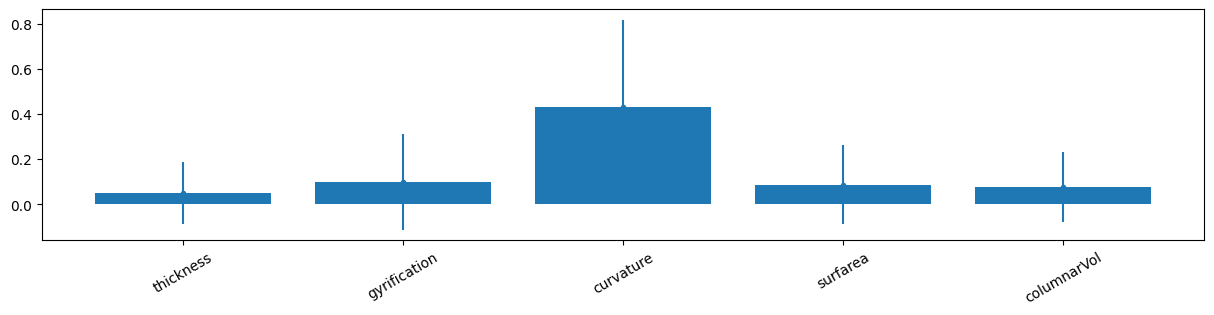

In [9]:
# instead of histograms, we will show a bar plot of the average and standard deviation
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(features),3))
plt.bar(range(len(features)),mfcorr)
plt.errorbar(range(len(features)),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(len(features)),labels=features,rotation=30)

## 3) Contextualize with other maps

  Input map    Subfields (R)    Subfields (p corrected)    A-P gradinet (R)    A-P gradinet (p corrected)  0th most correlated       0th (R)    0th (p corrected)  1th most correlated            1th (R)    1th (p corrected)  2th most correlated         2th (R)    2th (p corrected)
-----------  ---------------  -------------------------  ------------------  ----------------------------  ---------------------  ----------  -------------------  ---------------------------  ---------  -------------------  -----------------------  ----------  -------------------
          0        0.0844077                        0.2         0.116703                              0.8  MRI-7T-MTR             -0.281235                   0.1  MRI-3T-rsfMRI-avgFCneocort   0.24225                    0.3  MRI-3T-rsfMRI-IntTS       0.233951                   0.1
          1        0.356783                         0           0.0103582                             1    MRI-7T-MTR             -0.468608                  

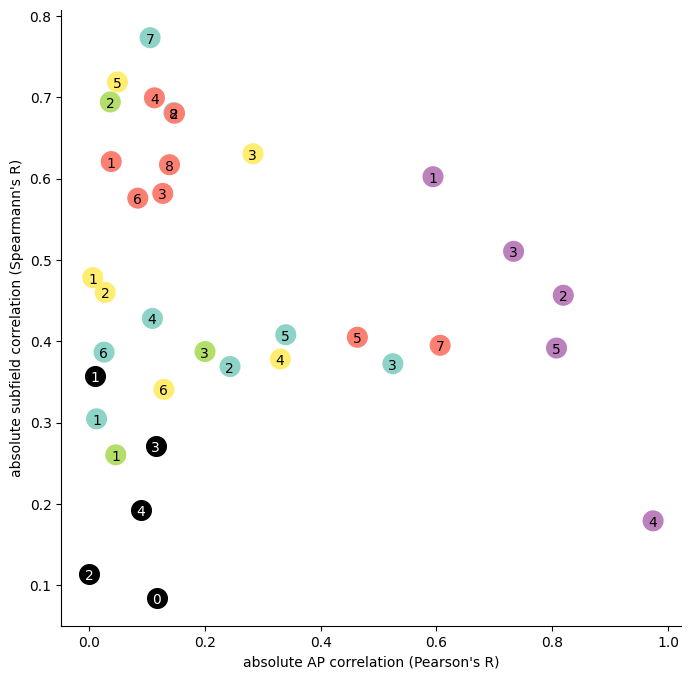

  Input map    Subfields (R)    Subfields (p corrected)    A-P gradinet (R)    A-P gradinet (p corrected)  0th most correlated       0th (R)    0th (p corrected)  1th most correlated      1th (R)    1th (p corrected)  2th most correlated       2th (R)    2th (p corrected)
-----------  ---------------  -------------------------  ------------------  ----------------------------  ---------------------  ----------  -------------------  ---------------------  ---------  -------------------  ----------------------  ---------  -------------------
          0        -0.326009                        0            0.170227                             0.7  MRI-7T-MTR             -0.305917                     0  MRI-7T-qT1             0.285621                   0.1  MRI-7T-T2star           0.2618                     0.4
          1         0.535358                        0            0.00319241                           1    MRI-7T-MTR             -0.508115                     0  MRI-7T-qT1        

In [10]:
t, ax = hm.stats.contextualize2D(asymmetry, nperm=10) # Note that for the sake of speed this nperm set low, but ideally it should be 10000

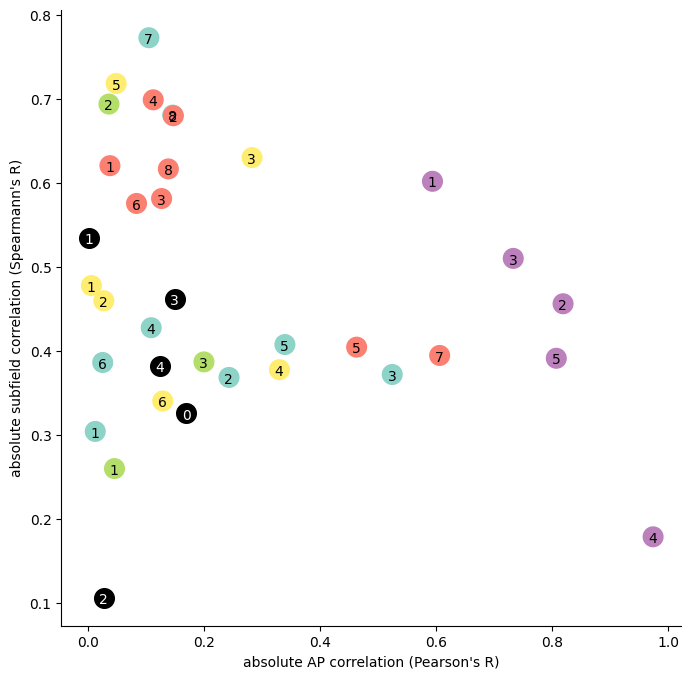

In [11]:
t, ax = hm.stats.contextualize2D(caseCtrl, nperm=10) # Note that for the sake of speed nperm is set low, but ideally it should be 10000

**save**

In [12]:
# save a copy of the 2D map
!mkdir -p ../maps/HippoMaps-initializationMaps/Dataset-MICs
for f,feature in enumerate(features):
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels):    
            cdat = caseCtrl[:,f]
            data_array = nib.gifti.GiftiDataArray(data=cdat.astype(np.float32))
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-MICs/MRI-3T-MRI-TLE-case-control-{feature}_average-{len(subs_PX)}_hemi-mix_den-2mm_label-{label}.shape.gii')

In [13]:
end_time = time.time()
duration = end_time - start_time
print(f"Total duration: {duration:.2f} seconds")
duration

2144.5898690223694